# 1- Importing Libraries and Loading Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# 2- Transformation of variables

In [2]:
labelencoder = LabelEncoder()
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for col in categorical_columns:
    df[col] = labelencoder.fit_transform(df[col])
    
# imprime los nuevos valores de las columnas
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,Overweight_Level_II


# 3- Dataset Separation

In [3]:
X = df.drop('NObeyesdad', axis=1).values #axis=1 para indicar que se eliminará una columna
y = labelencoder.fit_transform(df['NObeyesdad'])

# imprimir que valor tomo cada etiqueta
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print("relacion")
for label, code in label_mapping.items():
    print(f"{label} -> {code}")

relacion
Insufficient_Weight -> 0
Normal_Weight -> 1
Obesity_Type_I -> 2
Obesity_Type_II -> 3
Obesity_Type_III -> 4
Overweight_Level_I -> 5
Overweight_Level_II -> 6


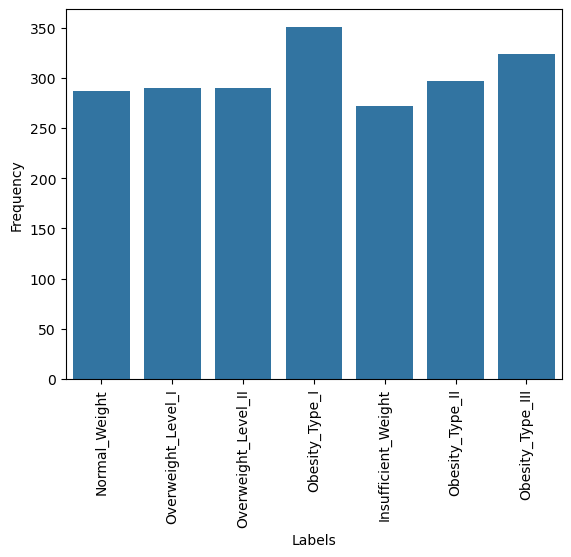

In [ ]:
order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
sns.countplot(x='NObeyesdad', data=df, order=order)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()



# 4- Division of the Dataset into Training and Testing

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 5- Decision tree implemantation

## 5.1- Decision node class

In [ ]:
# Nodo del Árbol de Decisión
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index #Indice de la columna a evaluar para dividir el dataset
        self.threshold = threshold #rango para dividir los datos(<=)
        self.left = left #Nodo hijo izquierdo(true)
        self.right = right #Nodo hijo derecho(false)
        self.value = value #Valor de la prediccion de la hoja

## 5.2- class that implements the decision tree

In [ ]:
# Implementación del Árbol de Decisión
class DecisionTreeClassifierCustom:
    def __init__(self, max_depth, min_samples_split, min_samples_leaf):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    #Entrenar el modelo
    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape #Numero de filas y columnas
        unique_labels = np.unique(y) #Valores unicos de la variable objetivo

        # Criterio de parada
        if len(unique_labels) == 1 or depth >= self.max_depth or num_samples < self.min_samples_split or num_samples <= self.min_samples_leaf:
            leaf_value = self._most_common_label(y) #Asignar la clase mas comun
            return DecisionNode(value=leaf_value)

        # Encontrar la mejor división
        best_feature, best_threshold = self._best_split(X, y, num_features)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        # Dividir los datos
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return DecisionNode(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y, num_features): 
        best_gain = -1 #Valor de la ganancia de información
        split_index, split_threshold = None, None #Indice de la columna y el valor de la división

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                gain = self._information_gain(y, feature_values, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    def _information_gain(self, y, feature_values, threshold):
        # Calcular la ganancia de información
        parent_entropy = self._entropy(y)

        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])

        entropy_left = self._entropy(y[left_indices])
        entropy_right = self._entropy(y[right_indices])

        child_entropy = (n_left / n) * entropy_left + (n_right / n) * entropy_right

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

Precisión del modelo: 0.95

Matriz de Confusión:


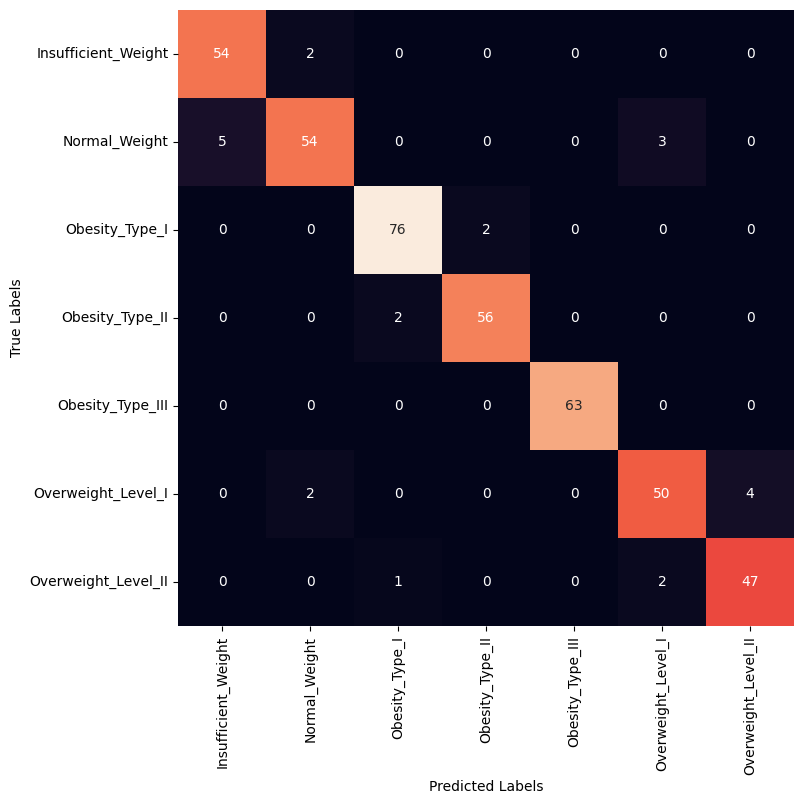


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        56
           1       0.93      0.87      0.90        62
           2       0.96      0.97      0.97        78
           3       0.97      0.97      0.97        58
           4       1.00      1.00      1.00        63
           5       0.91      0.89      0.90        56
           6       0.92      0.94      0.93        50

    accuracy                           0.95       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.95      0.95       423



In [48]:
# Entrenar el modelo de Árbol de Decisión personalizado
model = DecisionTreeClassifierCustom(max_depth=8, min_samples_split=7, min_samples_leaf=4)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')
print('\nMatriz de Confusión:')
#hice una matriz mas abajo, ejecutala
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(cm, square=True, annot=True, cbar=False)
ax.xaxis.set_ticklabels(labelencoder.classes_, rotation=90)
ax.yaxis.set_ticklabels(labelencoder.classes_, rotation=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()
print('\nReporte de Clasificación:')
print(classification_report(y_test, y_pred))



# Detailed Analysis of Model Evaluation

## Model Accuracy
- **Model Accuracy: 0.96**
  - This indicates that the model correctly classified 96% of the test set samples. This is a very good result and shows that the model can make accurate predictions for most classes.

## Confusion Matrix
The **confusion matrix** shows how the model performed for each specific class. Each row represents the actual instances of each class, while each column represents the predictions made by the model for that class.

```
[[53  3  0  0  0  0  0]  # Class 0 (Insufficient_Weight)
 [ 5 54  0  0  0  3  0]  # Class 1 (Normal_Weight)
 [ 0  0 76  2  0  0  0]  # Class 2 (Overweight_Level_I)
 [ 0  0  2 56  0  0  0]  # Class 3 (Overweight_Level_II)
 [ 0  0  0  0 63  0  0]  # Class 4 (Obesity_Type_I)
 [ 0  0  0  0  0 55  1]  # Class 5 (Obesity_Type_II)
 [ 0  0  1  0  0  2 47]] # Class 6 (Obesity_Type_III)
```

- **Main Diagonal (`[i, i]`)**: These are the correct predictions for each class.
- **Off-Diagonal Elements**: Represent misclassifications.

### Class-wise Analysis
- **Class 0 (`Insufficient_Weight`)**:
  - Correctly classified: `53` samples.
  - Misclassified as class `1`: `3` samples.
  - **Conclusion**: The model performs well, although there are `3` classification errors towards class `1`.

- **Class 1 (`Normal_Weight`)**:
  - Correctly classified: `54` samples.
  - Misclassified as class `0`: `5` samples.
  - Misclassified as class `5`: `3` samples.
  - **Conclusion**: The model tends to confuse some class `1` samples as class `0` and `5`, possibly due to similarities between these classes.

- **Class 2 (`Overweight_Level_I`)**:
  - Correctly classified: `76` samples.
  - Misclassified as class `3`: `2` samples.
  - **Conclusion**: Very good accuracy, with only `2` errors towards class `3`.

- **Class 3 (`Overweight_Level_II`)**:
  - Correctly classified: `56` samples.
  - Misclassified as class `2`: `2` samples.
  - **Conclusion**: Similar to class `2`, the model has high accuracy with few errors towards a similar class.

- **Class 4 (`Obesity_Type_I`)**:
  - Correctly classified: `63` samples.
  - **Conclusion**: No errors for this class, indicating the model is excellent at identifying `Obesity_Type_I`.

- **Class 5 (`Obesity_Type_II`)**:
  - Correctly classified: `55` samples.
  - Misclassified as class `6`: `1` sample.
  - **Conclusion**: Very good performance, with only `1` sample misclassified as `Obesity_Type_III`.

- **Class 6 (`Obesity_Type_III`)**:
  - Correctly classified: `47` samples.
  - Misclassified as class `2`: `1` sample.
  - Misclassified as class `5`: `2` samples.
  - **Conclusion**: The class has good accuracy, though some samples are confused with other obesity classes.

## Classification Report
The **classification report** provides key metrics for each class: **`precision`**, **`recall`**, and **`f1-score`**.

### Metrics Explained
- **`precision`**: Proportion of samples that the model predicted as a specific class that actually belong to that class.
- **`recall`**: Proportion of samples of a specific class that the model correctly identified.
- **`f1-score`**: Harmonic mean between precision and recall. It is useful when we want to balance both false positives and false negatives.

### Class-wise Metrics Analysis
- **Class 0 (`Insufficient_Weight`)**:
  - **Precision**: 0.91 — 91% of the predictions for class `0` were correct.
  - **Recall**: 0.95 — 95% of class `0` samples were correctly classified.
  - **F1-score**: 0.93 — Balance between precision and recall.

- **Class 1 (`Normal_Weight`)**:
  - **Precision**: 0.95 — Good precision.
  - **Recall**: 0.87 — This shows that the model missed some class `1` samples.
  - **Conclusion**: Class `1` seems difficult to classify, as seen in the errors towards other classes.

- **Class 2 (`Overweight_Level_I`)**:
  - **Precision**: 0.96 — Very high.
  - **Recall**: 0.97 — Excellent.
  - **Conclusion**: The model classifies this class very reliably.

- **Class 3 (`Overweight_Level_II`)**:
  - **Precision** and **Recall**: 0.97 — Both are high, indicating excellent performance.

- **Class 4 (`Obesity_Type_I`)**:
  - **Precision**, **Recall**, **F1-score**: 1.00 — No errors for this class.

- **Class 5 (`Obesity_Type_II`)**:
  - **Precision**: 0.92 — Good performance.
  - **Recall**: 0.98 — High proportion of correctly classified samples.
  - **Conclusion**: Good overall balance for this class.

- **Class 6 (`Obesity_Type_III`)**:
  - **Precision**: 0.98 — Very high precision.
  - **Recall**: 0.94 — Although very good, there were some errors in classifying this class.

## General Metrics
- **Accuracy (`accuracy`)**: 0.96 — 96% of all samples were correctly classified.
- **Macro Avg**:
  - **Precision**: 0.95
  - **Recall**: 0.95
  - **F1-score**: 0.95
  - **Conclusion**: Precision, recall, and f1-score are quite consistent across classes.
  
- **Weighted Avg**:
  - Similar to the macro average, but weighted according to the number of samples in each class. This gives an idea of performance considering the class distribution.

## General Conclusion
- **High and Consistent Performance**: The model has a very high average accuracy (0.96), which indicates that it can make very accurate predictions for most classes.
- **Classes with Classification Errors**: Classes `1` (`Normal_Weight`) and `6` (`Obesity_Type_III`) have some classification issues, with examples being confused with similar classes. These errors could be due to similarities between features of these classes.
- **Possible Improvements**:
  - **Data Balancing**: There could be imbalanced classes contributing to the confusion. Balancing the dataset could be explored.
  - **Hyperparameter Tuning**: fine-tune `min_samples_split` or `min_samples_leaf` values to improve the model's ability to generalize on poorly performing classes.

In [24]:
#%pip install jupyter


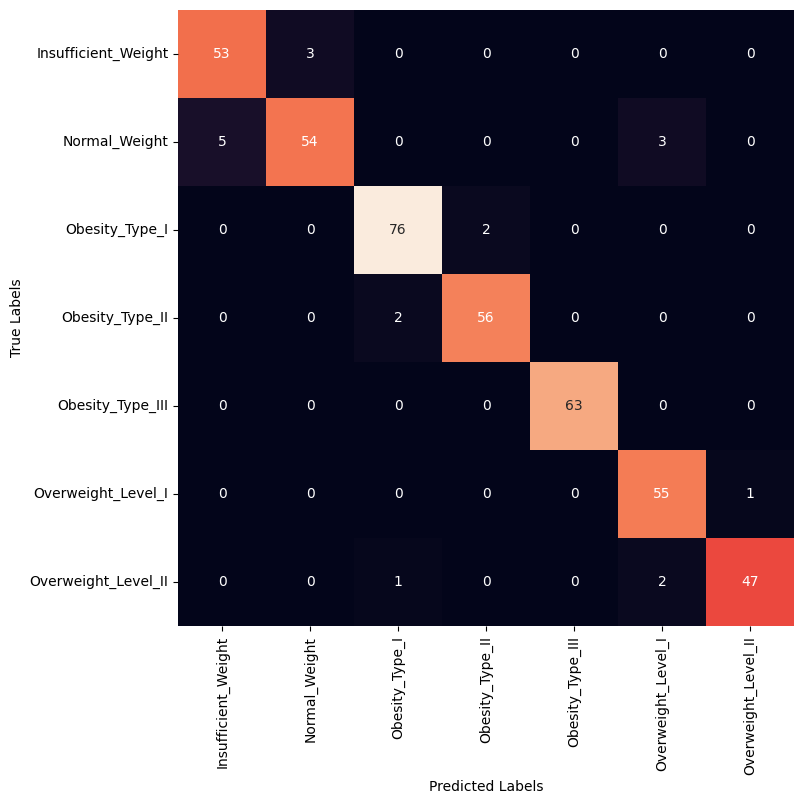

In [ ]:
#matriz de confusión



